# Diseño de Filtros FIR por el Método de Ventanas

## Introducción a los Filtros FIR

Los filtros de Respuesta Finita al Impulso (FIR, por sus siglas en inglés *Finite Impulse Response*) son un tipo de filtro digital ampliamente utilizado debido a sus propiedades deseables:

* **Estabilidad inherente:** Los filtros FIR son siempre estables, ya que su respuesta al impulso tiene una duración finita, lo que significa que no tienen realimentación de la salida.
* **Fase lineal:** Se pueden diseñar fácilmente filtros FIR con fase exactamente lineal, lo que es crucial en aplicaciones donde se debe preservar la forma de la onda (ej. audio, imágenes, señales biomédicas). Esto se logra si los coeficientes del filtro son simétricos o antisimétricos.

La operación de un filtro FIR se describe por la siguiente ecuación en diferencias, que es una suma ponderada de las muestras de entrada recientes y pasadas:
$$y[n] = \sum_{k=0}^{M} h[k] x[n-k]$$
Donde:
- $x[n]$ es la señal de entrada.
- $y[n]$ es la señal de salida filtrada.
- $h[k]$ son los coeficientes del filtro FIR, que corresponden directamente a su respuesta al impulso.
- $M$ es el **orden** del filtro. La **longitud** del filtro es $L = M+1$.

## Método de Diseño por Ventanas

El diseño de filtros FIR por el método de ventanas es una técnica conceptualmente sencilla para obtener los coeficientes $h[k]$. La idea básica es:
1.  Comenzar con la respuesta en frecuencia ideal deseada (ej. un pasabajos ideal, un pasaaltas ideal, etc.).
2.  Obtener la respuesta al impulso $h_d[n]$ correspondiente a este filtro ideal mediante la Transformada de Fourier Inversa. Esta $h_d[n]$ suele ser de duración infinita y no causal.
3.  Truncar y modificar $h_d[n]$ para obtener una respuesta al impulso finita y causal $h[n]$ de longitud $L$. Este truncamiento se realiza multiplicando $h_d[n]$ por una **función de ventana** $w[n]$ de longitud $L$:
    $$h[n] = h_d[n - M/2] \cdot w[n], \quad \text{para } 0 \le n \le M$$
    (El término $n-M/2$ en $h_d$ se usa para centrar la respuesta ideal alrededor del punto medio de la ventana y así obtener un filtro causal con fase lineal si $h_d$ y $w$ son simétricos).

El simple truncamiento (equivalente a usar una ventana rectangular) introduce discontinuidades abruptas, lo que resulta en oscilaciones indeseadas en la respuesta en frecuencia del filtro diseñado, conocidas como el **Fenómeno de Gibbs**. Las funciones de ventana más sofisticadas buscan suavizar estas transiciones para reducir dichas oscilaciones y mejorar el compromiso entre el ancho del lóbulo principal y la atenuación de los lóbulos laterales en la respuesta en frecuencia.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Configuración general para los gráficos
plt.rcParams['figure.figsize'] = [10, 4] # Tamaño de figura por defecto
plt.rcParams['figure.dpi'] = 90         # Resolución de figura por defecto

# --- Funciones para graficar en el Dominio del Tiempo ---

def plot_signal_time_domain(t, signal_data, title="Señal en el Dominio del Tiempo", xlabel="Tiempo (s)", ylabel="Amplitud"):
    """Grafica una señal (amplitud vs. tiempo) dado un vector de tiempo 't'."""
    plt.figure()
    plt.plot(t, signal_data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def plot_impulse_response(h_coeffs, title="Respuesta al Impulso h[n]", xlabel="Muestras (n)", ylabel="Amplitud"):
    """Grafica una respuesta al impulso (h[n] vs. n), usando un stem plot."""
    plt.figure()
    # Intenta usar use_line_collection=True para compatibilidad con versiones nuevas de Matplotlib
    try:
        markerline, stemlines, baseline = plt.stem(np.arange(len(h_coeffs)), h_coeffs, basefmt=" ", use_line_collection=True)
        plt.setp(markerline, markersize=4)
    except TypeError: # Para versiones más antiguas que no reconocen use_line_collection
        plt.stem(np.arange(len(h_coeffs)), h_coeffs, basefmt=" ")
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', lw=0.5) # Línea base en cero
    plt.show()

# --- Funciones para graficar en el Dominio de la Frecuencia ---

def plot_freq_response(w_freq_axis, h_complex_response, title="Respuesta en Frecuencia del Filtro", fs=None):
    """
    Grafica la respuesta de magnitud (dB) y fase de un FILTRO.
    w_freq_axis: eje de frecuencias (ya sea normalizado o en Hz si fs se provee).
    h_complex_response: respuesta compleja del filtro (salida de signal.freqz).
    fs: frecuencia de muestreo (opcional, para interpretar y etiquetar el eje en Hz).
    """
    fig, axs = plt.subplots(2, 1, figsize=(10,6))
    
    magnitude_db = 20 * np.log10(np.abs(h_complex_response) + 1e-9) # +1e-9 para evitar log(0)

    freq_axis_label = 'Frecuencia (Hz)' if fs else 'Frecuencia Normalizada'
    w_freq_axis_plot = w_freq_axis 

    if not fs: 
        if np.max(w_freq_axis) <= (np.pi + 1e-3) and np.min(w_freq_axis) >= 0 : # Asumir que w está en rad/muestra [0, pi]
             freq_axis_label = 'Frecuencia Normalizada (x $\pi$ rad/muestra)'
             w_freq_axis_plot = w_freq_axis / np.pi
        elif np.max(w_freq_axis) <= (0.5 + 1e-3) and np.min(w_freq_axis) >= 0: # Asumir que w está en ciclos/muestra [0, 0.5]
             freq_axis_label = 'Frecuencia Normalizada (ciclos/muestra)'
    # Si fs se da, se asume que w_freq_axis ya está en Hz y w_freq_axis_plot no necesita cambio

    axs[0].plot(w_freq_axis_plot, magnitude_db)
    axs[0].set_title(f'{title} - Magnitud')
    axs[0].set_xlabel(freq_axis_label)
    axs[0].set_ylabel('Magnitud (dB)')
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].set_ylim([-120, max(np.max(magnitude_db) + 10, 10)]) # Asegurar un rango visible

    phase = np.unwrap(np.angle(h_complex_response))
    axs[1].plot(w_freq_axis_plot, phase)
    axs[1].set_title(f'{title} - Fase (desenvuelta)')
    axs[1].set_xlabel(freq_axis_label)
    axs[1].set_ylabel('Fase (radianes)')
    axs[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_dft_spectrum(freq_axis_hz, dft_coeffs_complex, title="Espectro de la DFT (Señal)", shift_spectrum=True):
    """
    Grafica el espectro de magnitud y fase de la DFT de una SEÑAL.
    Aplica fftshift por defecto para centrar la frecuencia cero.
    freq_axis_hz: Eje de frecuencias en Hz (resultado de np.fft.fftfreq).
    dft_coeffs_complex: Coeficientes de la DFT (resultado de np.fft.fft).
    """
    dft_coeffs_to_plot = dft_coeffs_complex
    freq_axis_to_plot_hz = freq_axis_hz

    if shift_spectrum:
        dft_coeffs_to_plot = np.fft.fftshift(dft_coeffs_complex)
        freq_axis_to_plot_hz = np.fft.fftshift(freq_axis_hz)

    magnitude_spectrum = np.abs(dft_coeffs_to_plot)
    phase_spectrum = np.angle(dft_coeffs_to_plot)
    unwrapped_phase_spectrum = np.unwrap(phase_spectrum)

    fig, axs = plt.subplots(2, 1, figsize=(10,6))

    axs[0].plot(freq_axis_to_plot_hz, magnitude_spectrum)
    axs[0].set_title(f'{title} - Magnitud')
    axs[0].set_xlabel('Frecuencia (Hz)')
    axs[0].set_ylabel('|X(k)| (Magnitud DFT)')
    axs[0].grid(True, linestyle='--', alpha=0.7)
    # Ajustar límites x si se hizo shift para ver el espectro completo centrado
    if shift_spectrum and len(freq_axis_to_plot_hz) > 0:
      axs[0].set_xlim([np.min(freq_axis_to_plot_hz), np.max(freq_axis_to_plot_hz)])

    axs[1].plot(freq_axis_to_plot_hz, unwrapped_phase_spectrum)
    axs[1].set_title(f'{title} - Fase (desenvuelta)')
    axs[1].set_xlabel('Frecuencia (Hz)')
    axs[1].set_ylabel('Fase (radianes)')
    axs[1].grid(True, linestyle='--', alpha=0.7)
    if shift_spectrum and len(freq_axis_to_plot_hz) > 0:
      axs[1].set_xlim([np.min(freq_axis_to_plot_hz), np.max(freq_axis_to_plot_hz)])

    plt.tight_layout()
    plt.show()

<>:56: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\p'
C:\Users\maxim\AppData\Local\Temp\ipykernel_24412\2533884653.py:56: SyntaxWarning: invalid escape sequence '\p'
  freq_axis_label = 'Frecuencia Normalizada (x $\pi$ rad/muestra)'


## Funciones de Ventana Comunes

Existen diversas funciones de ventana, cada una ofreciendo un compromiso diferente entre el ancho del lóbulo principal (relacionado con la rapidez de la transición) y la atenuación de los lóbulos laterales (relacionado con el rizado en las bandas de paso y rechazo). Algunas comunes son:

* **Rectangular (o Boxcar):** $w[n] = 1$, para $0 \le n \le M$. Produce el lóbulo principal más estrecho pero la peor atenuación de lóbulos laterales (~ -13 dB).
* **Triangular (o Bartlett):** Linealmente creciente y luego decreciente. Mejor atenuación que la rectangular (~ -27 dB).
* **Hanning (o Hann):** $w[n] = 0.5 \left(1 - \cos\left(\frac{2\pi n}{M}\right)\right)$. Lóbulos laterales de ~ -32 dB.
* **Hamming:** $w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{M}\right)$. Similar a Hanning, pero optimizada para cancelar el primer lóbulo lateral, logrando una atenuación de ~ -43 dB para los lóbulos más lejanos.
* **Blackman:** $w[n] = 0.42 - 0.5 \cos\left(\frac{2\pi n}{M}\right) + 0.08 \cos\left(\frac{4\pi n}{M}\right)$. Lóbulos laterales considerablemente más bajos (~ -58 dB), a costa de un lóbulo principal más ancho.
* **Kaiser:** $w[n] = \frac{I_0\left(\beta \sqrt{1 - \left(\frac{n - M/2}{M/2}\right)^2}\right)}{I_0(\beta)}$. Es una ventana muy flexible que, mediante el parámetro $\beta$, permite ajustar el compromiso entre el ancho del lóbulo principal y la atenuación de los lóbulos laterales. $I_0$ es la función de Bessel modificada de primera especie de orden cero.

La elección de la ventana y su longitud (orden $M$) depende de las especificaciones del filtro.

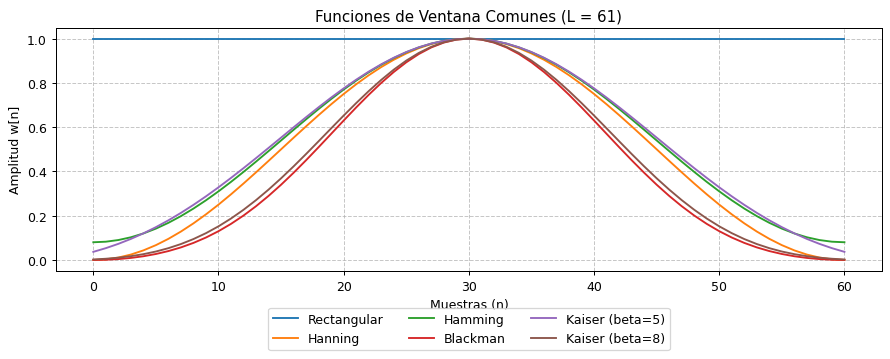

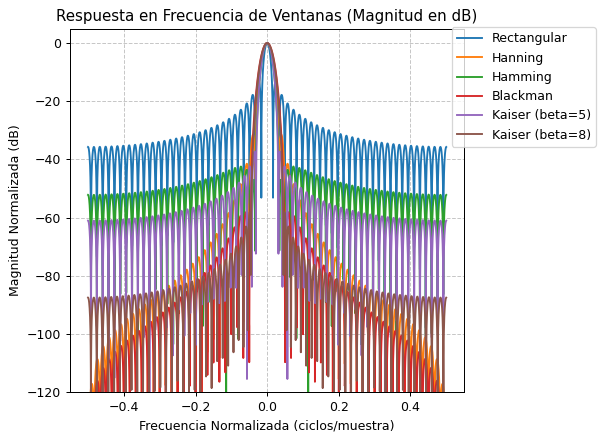

In [2]:
L = 61 # Longitud de la ventana (Orden M = L - 1)

windows_to_plot = {
    "Rectangular": signal.windows.boxcar(L),
    "Hanning": signal.windows.hann(L),
    "Hamming": signal.windows.hamming(L),
    "Blackman": signal.windows.blackman(L),
    "Kaiser (beta=5)": signal.windows.kaiser(L, beta=5),
    "Kaiser (beta=8)": signal.windows.kaiser(L, beta=8)
}

plt.figure(figsize=(10, 5))
for name, win_data in windows_to_plot.items():
    plt.plot(win_data, label=name)
plt.title(f'Funciones de Ventana Comunes (L = {L})')
plt.xlabel('Muestras (n)')
plt.ylabel('Amplitud w[n]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0.1, 1, 1]) # Ajustar para leyenda
plt.show()


# Visualizar los espectros de las ventanas
plt.figure(figsize=(10, 5))
num_fft_points = 4096 # Puntos para una DFT suave (zero-padding)

for name, win_data in windows_to_plot.items():
    # Aplicar zero-padding para una mejor visualización de la forma del lóbulo
    padded_window = np.zeros(num_fft_points)
    padded_window[:L] = win_data # Centrar o no la ventana puede afectar la fase, pero no la magnitud

    dft_window = np.fft.fft(padded_window)
    # Centrar el espectro para visualización
    dft_window_shifted = np.fft.fftshift(dft_window)
    freq_axis = np.fft.fftshift(np.fft.fftfreq(num_fft_points)) # Frecuencia normalizada [-0.5, 0.5)

    # Magnitud en dB, normalizada al pico del lóbulo principal
    magnitude_db = 20 * np.log10(np.abs(dft_window_shifted) / np.max(np.abs(dft_window_shifted)) + 1e-9)
    
    plt.plot(freq_axis, magnitude_db, label=name)

plt.ylim([-120, 5])
plt.title('Respuesta en Frecuencia de Ventanas (Magnitud en dB)')
plt.xlabel('Frecuencia Normalizada (ciclos/muestra)')
plt.ylabel('Magnitud Normalizada (dB)')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.02))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0,0,0.8,1]) # Ajustar para leyenda
plt.show()

## Diseño de un Filtro Pasabajos FIR con `scipy.signal.firwin`

La función `scipy.signal.firwin` es una herramienta conveniente que implementa el método de diseño de filtros FIR por ventanas. Permite especificar la longitud del filtro (`numtaps`), la(s) frecuencia(s) de corte, el tipo de ventana y, opcionalmente, la frecuencia de muestreo.

**Pasos Típicos:**
1.  **Definir Especificaciones:**
    * Frecuencia de muestreo ($f_s$).
    * Frecuencia de corte deseada ($f_c$).
    * Ancho de la banda de transición ($\Delta f$).
    * Rizado en la banda de paso y atenuación en la banda de rechazo (esto guía la elección de la ventana y el orden).
2.  **Estimar el Orden del Filtro ($M$) / Longitud ($L=M+1$):**
    El ancho de la banda de transición está inversamente relacionado con la longitud del filtro y depende del tipo de ventana. Para una ventana dada, $\Delta f \approx \frac{c \cdot f_s}{L}$, donde $c$ es una constante que depende de la ventana (ej. $c \approx 4$ para Hamming/Hanning, $c \approx 5.5$ para Blackman). Entonces, $L \approx \frac{c \cdot f_s}{\Delta f}$. Se suele redondear $L$ al entero impar más cercano para filtros Tipo I (simétricos con $M$ par).
3.  **Seleccionar una Ventana:** Basado en la atenuación requerida en la banda de rechazo.
4.  **Generar los Coeficientes del Filtro:** Usar `signal.firwin`.
5.  **Analizar la Respuesta en Frecuencia:** Usar `signal.freqz`.

Filtro Pasabajos Deseado:
  Frecuencia de corte: 400.0 Hz
  Ancho de transición: 100.0 Hz
  Atenuación banda de rechazo: >= 60 dB
Ventana Kaiser calculada:
  Longitud L (numtaps): 75
  Parámetro Beta: 5.65

Primeros 10 coeficientes del filtro h[n]: [ 0.0001   0.00025 -0.      -0.00049 -0.0004   0.00051  0.00104 -0.
 -0.00158 -0.00119]


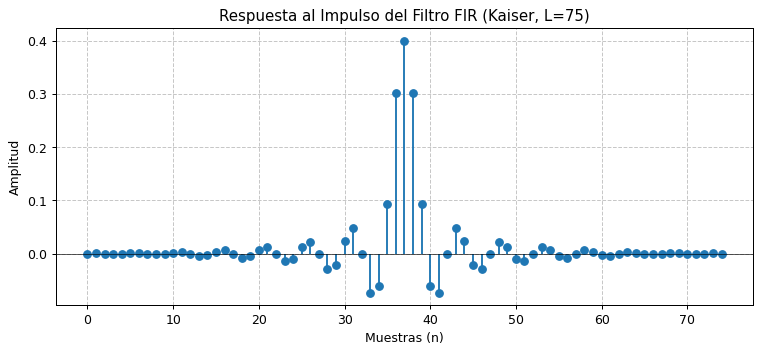

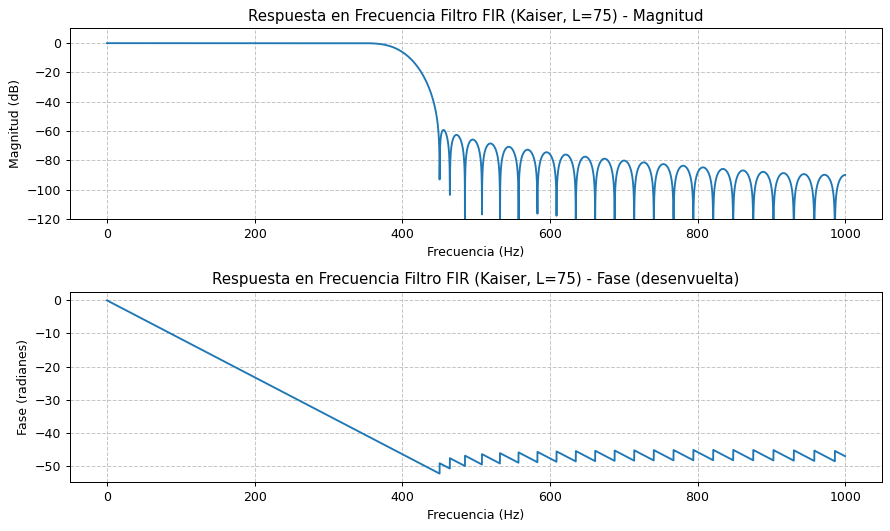

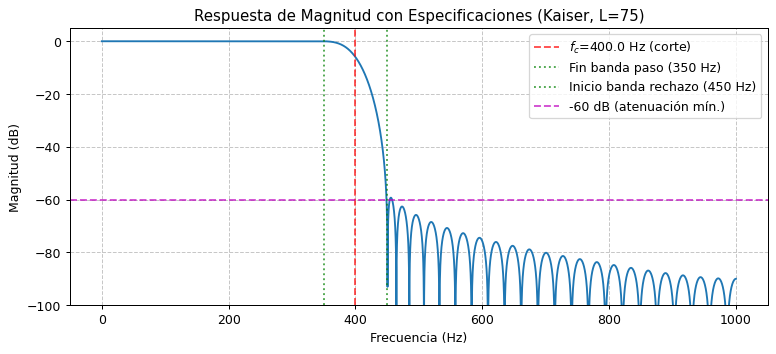

In [3]:
# 1. Especificaciones del filtro
fs = 2000.0      # Frecuencia de muestreo (Hz)
nyq_freq = fs / 2.0 # Frecuencia de Nyquist
cutoff_freq = 400.0 # Frecuencia de corte deseada (Hz)
transition_width = 100.0 # Ancho de la banda de transición deseado (Hz)
stop_band_attenuation_db = 60 # Atenuación deseada en la banda de rechazo (dB)

# 2. Estimar longitud y 3. Seleccionar ventana
normalized_transition_width = transition_width / nyq_freq
num_taps_L, beta_kaiser = signal.kaiserord(stop_band_attenuation_db, normalized_transition_width)
if num_taps_L % 2 == 0: # Asegurar longitud impar para simetría tipo I (M par)
    num_taps_L += 1

print(f"Filtro Pasabajos Deseado:")
print(f"  Frecuencia de corte: {cutoff_freq} Hz")
print(f"  Ancho de transición: {transition_width} Hz")
print(f"  Atenuación banda de rechazo: >= {stop_band_attenuation_db} dB")
print(f"Ventana Kaiser calculada:")
print(f"  Longitud L (numtaps): {num_taps_L}")
print(f"  Parámetro Beta: {beta_kaiser:.2f}")

# 4. Generar los coeficientes del filtro usando signal.firwin
fir_coeffs = signal.firwin(numtaps=num_taps_L,
                           cutoff=cutoff_freq,
                           window=('kaiser', beta_kaiser),
                           fs=fs,
                           pass_zero='lowpass')

print(f"\nPrimeros 10 coeficientes del filtro h[n]: {np.round(fir_coeffs[:10], 5)}")
# LLAMADA CORREGIDA/CONFIRMADA:
plot_impulse_response(fir_coeffs, title=f"Respuesta al Impulso del Filtro FIR (Kaiser, L={num_taps_L})")

# 5. Analizar la respuesta en frecuencia
w_hz, h_complex = signal.freqz(fir_coeffs, worN=8000, fs=fs)
plot_freq_response(w_hz, h_complex, title=f"Respuesta en Frecuencia Filtro FIR (Kaiser, L={num_taps_L})", fs=fs)

# Graficar de nuevo la magnitud con las especificaciones para una mejor evaluación
plt.figure(figsize=(10,4)) # Esta es una gráfica separada, no usa las funciones auxiliares directamente
plt.plot(w_hz, 20 * np.log10(np.abs(h_complex) + 1e-9))
plt.axvline(cutoff_freq, color='r', linestyle='--', alpha=0.7, label=f'$f_c$={cutoff_freq} Hz (corte)')
pass_band_end = cutoff_freq - transition_width / 2
stop_band_start = cutoff_freq + transition_width / 2
plt.axvline(pass_band_end, color='g', linestyle=':', alpha=0.7, label=f'Fin banda paso ({pass_band_end:.0f} Hz)')
plt.axvline(stop_band_start, color='g', linestyle=':', alpha=0.7, label=f'Inicio banda rechazo ({stop_band_start:.0f} Hz)')
plt.axhline(-stop_band_attenuation_db, color='m', linestyle='--', alpha=0.7, label=f'-{stop_band_attenuation_db} dB (atenuación mín.)')
plt.title(f'Respuesta de Magnitud con Especificaciones (Kaiser, L={num_taps_L})')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.ylim([-stop_band_attenuation_db - 40, 5])
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Aplicación del Filtro Diseñado

Una vez que tenemos los coeficientes $h[n]$ del filtro FIR, podemos aplicarlo a una señal de entrada $x[n]$ usando la operación de convolución. En `scipy.signal`, esto se puede hacer eficientemente con `signal.lfilter` o `signal.convolve`.

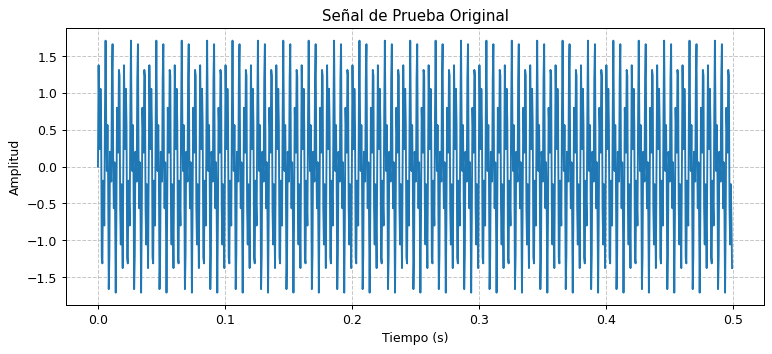

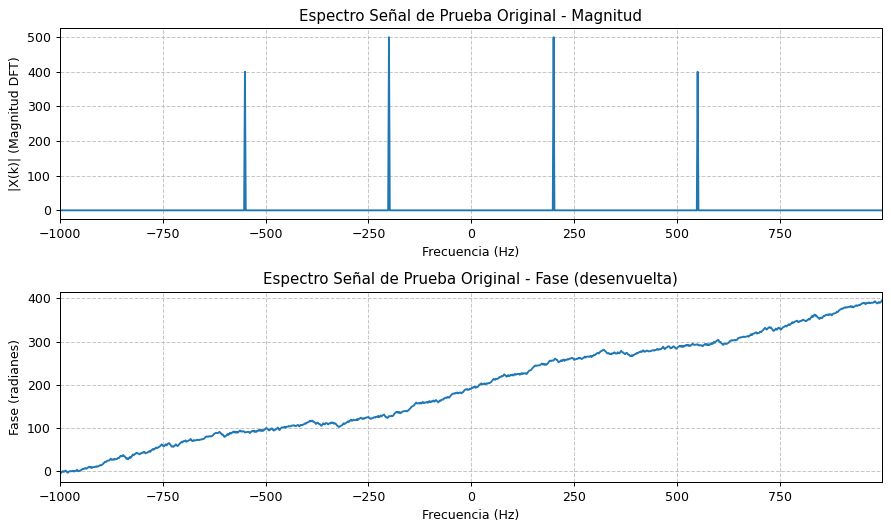

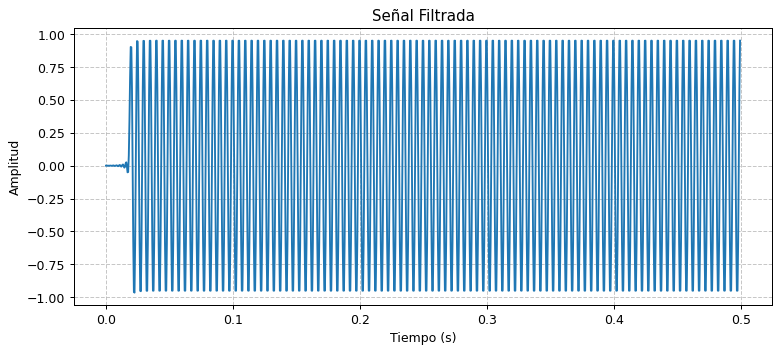

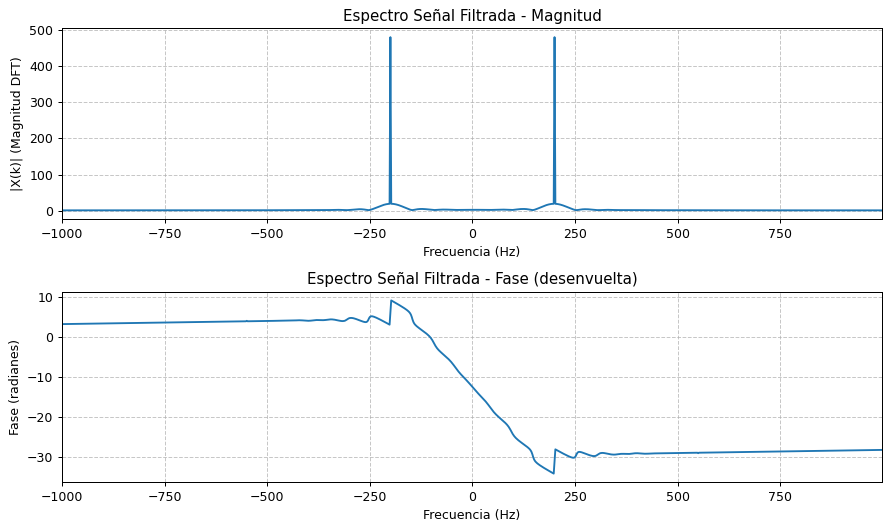


Señal de prueba compuesta por f_pass=200.0 Hz y f_stop=550.0 Hz.
Frecuencia de corte del filtro: 400.0 Hz.
Se espera que el filtro atenúe significativamente la componente de f_stop Hz.


In [4]:
# Generar una señal de prueba con componentes dentro y fuera de la banda de paso
t_test = np.arange(0, 0.5, 1/fs) # 0.5 segundos de señal

f_pass = cutoff_freq / 2.0      # Componente en la banda de paso
sig_pass = 1.0 * np.sin(2 * np.pi * f_pass * t_test)
f_stop = stop_band_start + transition_width # Componente bien entrada en la banda de rechazo
sig_stop = 0.8 * np.sin(2 * np.pi * f_stop * t_test)
test_signal = sig_pass + sig_stop

plot_signal_time_domain(t_test, test_signal, title="Señal de Prueba Original")

# Calcular y graficar espectro de la señal de prueba
N_test = len(test_signal)
dft_test_coeffs_orig = np.fft.fft(test_signal)
freq_test_axis_hz = np.fft.fftfreq(N_test, d=1/fs)
plot_dft_spectrum(freq_test_axis_hz, dft_test_coeffs_orig, title="Espectro Señal de Prueba Original")


# Filtrar la señal
filtered_signal = signal.lfilter(b=fir_coeffs, a=[1.0], x=test_signal)

plot_signal_time_domain(t_test, filtered_signal, title="Señal Filtrada")

# Calcular y graficar espectro de la señal filtrada
dft_filtered_coeffs = np.fft.fft(filtered_signal)
plot_dft_spectrum(freq_test_axis_hz, dft_filtered_coeffs, title="Espectro Señal Filtrada")

print(f"\nSeñal de prueba compuesta por f_pass={f_pass:.1f} Hz y f_stop={f_stop:.1f} Hz.")
print(f"Frecuencia de corte del filtro: {cutoff_freq:.1f} Hz.")
print("Se espera que el filtro atenúe significativamente la componente de f_stop Hz.")